# Read and process groundwater data ILVO Field

Load essential Python modules

In [1]:
import pandas as pd
import xlrd
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
#from pandasql import sqldf
import datetime
import csv
import pdb
from tqdm.notebook import tqdm
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FuncFormatter
def minor_formatter(x, ind):
    # only format if we don't overlap with a major tick
    if np.mod(x, 1) < .1:
        return ''
    return '{:.1f}'.format(np.mod(x, 1))
def alternate_formatter(x, ind):
    rm = np.mod(x, 1)
    if np.abs(rm) < .1:
        return '{:d}'.format(int(x))
    return '{:.1f}'.format(rm)
%matplotlib ipympl

#!pip install traces

### Read Climate Data  (www.dacom.nl)

In [2]:
%matplotlib ipympl
#hourly data=dacom_weather_data, dailydata=dacom_weather_day
path1 = os.getcwd()
path = os.path.join(path1, 'data', 'raw_data')

#dacomdailyfile = os.path.join(path, 'dacom_weather_day.csv')
#dacomdaily=pd.read_csv(dacomdailyfile,sep=';',dayfirst=True)
#dacomdaily['Date']=pd.to_datetime(dacomdaily['Date'].str.replace('/', '-'), errors='coerce')
#dacomdaily=dacomdaily.set_index('Date')
#print(dacomdaily)

file = os.path.join(path, 'dacom_weather_data.csv')
#climate data from  www.dacom.nl
clim=pd.read_csv(file,sep=';')
clim['date'] = pd.to_datetime(clim['date'], format = '%m/%d/%Y')
print(clim)

climday = clim.groupby(clim.date.dt.floor('d')).agg({'precipitation': ['sum']})
climday.columns  = ['_'.join(col) for col in climday.columns.values]
climday.reset_index(inplace=True)
print(climday)

#climdaily=clim.resample('D', how='sum')#, 'air_temperature': np.mean,'rel_humidity': np.mean})

#climdaily=clim.resample('1d', origin=clim.index.max().ceil('D'),closed='right', label='right').sum()
#(climdaily)
#print(clim.date_time.dtype)
#climdaily.reset_index().plot(kind='scatter', x='date_time', y='precipitation')

#climday.to_excel('saved_climfile2.xlsx')


           date      time  air_temperature  rel_humidity  precipitation  \
0    2022-05-17  12:00 AM            15.57         90.16            0.0   
1    2022-05-17   1:00 AM            15.20         95.71            0.0   
2    2022-05-17   2:00 AM            15.11         97.59            0.0   
3    2022-05-17   3:00 AM            14.91         92.53            0.0   
4    2022-05-17   4:00 AM            14.72        100.00            0.0   
...         ...       ...              ...           ...            ...   
4547 2022-11-22  10:00 AM             6.02        100.00            0.0   
4548 2022-11-22  11:00 AM             6.46        100.00            0.0   
4549 2022-11-22  12:00 PM             7.03        100.00            0.0   
4550 2022-11-22   1:00 PM             7.73        100.00            0.0   
4551 2022-11-22   2:00 PM             8.30        100.00            0.0   

      wind_speed  wind_direction  radiation  radiation_short  
0           0.54          164.34    

In [3]:
#### COMPARING HOURLY AND DAILY DATA ####

#%matplotlib ipympl
#clim.groupby(clim.date.dt.floor('d')).sum().reset_index()
#plt.plot(climday.precipitation_sum)
#plt.plot(dacomdaily.index,dacomdaily.Prec)

#clim3 = clim2.loc[((clim2['precipitation'] == 0))] 

#ie=clim2['precipitation']> 0
#clim3=clim2[ie]
#print(clim3)
#plt.scatter(clim2.index,clim2.precipitation)
#print(sum(climday.precipitation_sum),sum(dacomdaily.Prec))



### Read data

In [4]:
datapath =  os.path.join(path1, 'data')
baro_ind='AP825'
xls_files = glob.glob(datapath + "\*.xlsx") # change to csv 
#barometer felt down in pipe on   '2022-05-25 07:25:00'  
#loop over the list of xls files
ind = 0
diver_names={}
alldf={}
for i,f in tqdm(enumerate(xls_files),total=len(xls_files)):
    # read the csv file
    df = pd.read_excel(f)
    #print(df)
    # remove double copied parts of the logged data from the raw data files
    df=df.drop_duplicates()  
    df=df.assign(Date=df.TimeStamp.dt.round('H'))
    
    df['Date']=pd.to_datetime(df['Date'],dayfirst=True)
    df=df.loc[(df['TimeStamp'] > '2022-08-02 12:00:00')]
    dfdaily=df.resample('D', on = 'Date').mean()

    # merge all data in 1 dataframe
    if baro_ind in f:
        baro_data=df
        baro_data=baro_data.loc[(baro_data['TimeStamp'] > '2022-08-02 12:00:00')]
        #baro_data=baro_data.append.df# this tests for substrings
    if ind == 0:
        #First data frame loaded
        GWdata = df
        GWdata_daily = dfdaily
    else:
        # Paste the rest to this dataframe
        GWdata = pd.concat([GWdata,df],axis=0).reset_index(drop=True)
        GWdata_daily = pd.concat([GWdata_daily,df],axis=0).reset_index(drop=True)
        alldf[i]=df
        alldf[i]=alldf[i].loc[(alldf[i]['TimeStamp'] > '2022-08-02 12:00:00')]
        GWdata
    ind = ind + 1 
#Remove empty columns from the dataframe    
#GWdata.drop(labels=['Conductivity', 'WaterLevel','WaterLevelReference'], axis=1)
#GWdata.loc[GWdata["SerialNumber"]=='AP825'].reset_index()
#baro_data.reset_index()

print(GWdata)
print(baro_data)
#GWdata.to_excel('saved_file1.xlsx')


  0%|          | 0/29 [00:00<?, ?it/s]

      MonitoringPoint SerialNumber           TimeStamp     Pressure  \
0                ILVO        AP689 2022-08-02 12:30:00  1099.600000   
1                ILVO        AP689 2022-08-02 13:00:00  1099.325000   
2                ILVO        AP689 2022-08-02 13:30:00  1098.866667   
3                ILVO        AP689 2022-08-02 14:00:00  1098.775000   
4                ILVO        AP689 2022-08-02 14:30:00  1098.591667   
...               ...          ...                 ...          ...   
46205            ILVO        AZ649 2022-11-04 07:00:00          NaN   
46206            ILVO        AZ649 2022-11-04 08:00:00          NaN   
46207            ILVO        AZ649 2022-11-04 09:00:00          NaN   
46208            ILVO        AZ649 2022-11-04 10:00:00          NaN   
46209            ILVO        AZ649 2022-11-04 11:00:00          NaN   

       Temperature  Conductivity  WaterLevel  WaterLevelReference  \
0        15.203333           NaN         NaN                  NaN   
1        

In [5]:
# Read manually measured water dephts for inspection of the data    
path_obs=os.path.join(path1, 'data','raw_data')
file_obs = os.path.join(path_obs, 'manual_check_water_depth.xlsx')
df_info = pd.read_excel(file_obs)
df_info['Time']=pd.to_datetime(df_info['Time'],dayfirst=True)
(df_info.Time)
df_info2=df_info[df_info.Time.notnull()]
df_info2=df_info2.reset_index(drop=True)
df_info2.iloc[:,3] = (-100*df_info2.iloc[:,3]) 
df_info2.iloc[:,4] =-100*df_info2.iloc[:,4] 
groups = df_info2.groupby('SerialNumber')
colors = {'AG083':'#ff7f0e','AP707': '#8c564b','CA186': '#d62728','AZ649': '#2ca02c', 'CA969':'#9467bd'}
print(df_info2)

   piezometer SerialNumber                Time  Measured Depth  \
0           a        AG083 2022-08-02 17:00:00          -215.0   
1           a        AG083 2022-08-18 09:36:00          -216.0   
2           a        AG083 2022-09-09 10:25:00          -224.0   
3           a        AG083 2022-09-14 15:17:00          -221.0   
4           a        AG083 2022-09-20 10:04:00          -215.0   
5           a        AG083 2022-10-17 15:45:00          -202.0   
6           a        AG083 2022-11-21 15:00:00          -176.0   
7           b        AP707 2022-08-02 17:50:00          -210.0   
8           b        AP707 2022-08-18 09:40:00          -205.0   
9           b        AP707 2022-09-09 10:30:00          -210.0   
10          b        AP707 2022-09-14 15:00:00          -208.0   
11          b        AP707 2022-09-20 10:15:00          -200.0   
12          b        AP707 2022-10-17 15:45:00          -189.0   
13          b        AP707 2022-11-21 15:00:00          -168.0   
14        

## Processing steps

Dataset Processing explanation						
1. Collect total pressure (TP) from divers		 (cmH2O)				
2. Calculate water pressure (WP) = TP - AP		 (cmH2O)		
3. Calculate hydraulic gradient. Take the timestep "t" at which a manual measurement is realized and calculate the hydraulic head						
     - H(t) = TW-WD(t)						
     - H (t+1) = H(t)  + (WP (t+1) - WP (t))/100						
																	
With :											
AP= Air Pressure (cmH20)											
H=Hydraulic Head (mTAW)						
TW=Top well Elevation (mTAW)						
WD=Water depth from the top well (m)												
						
| well   name | well   name | soil elevation(mTAW) | well height above the ground (m) | Top well (mTAW) | rope length (m)|
|:-----------:|:-----------:|:--------------------:|:--------------------------------:|:---------------:|:------------|
|  AG083  |   a   |         21,30        |                 0.56                |      21,86      |    |
|   AP707   |   b   |        20,5        |               0.43               |      20.93      |      |
|   CA186  |   c   |       19,7         |               0.63               |        20.33    |        |
|   AZ649   |   d   |         20,9        |              0.68                |      21.58      |      |
|   CA969  |  e  |         22,3        |                0.7               |      23.0     |       |
|   AP689   |     |                 |                            |            |           |

In [6]:
path1 = os.getcwd()
path = os.path.join(path1, 'data')
file = os.path.join(path, 'PiezoD1.csv')
PiezoD=pd.read_csv(file,sep=';',dayfirst=True)

print(PiezoD)

      Unnamed: 0  index MonitoringPoint SerialNumber         TimeStamp  \
0              0      0            ILVO        AZ649   2/08/2022 13:00   
1              1      1            ILVO        AZ649   2/08/2022 13:00   
2              2      2            ILVO        AZ649   2/08/2022 13:00   
3              3      3            ILVO        AZ649   2/08/2022 13:00   
4              4      7            ILVO        AZ649   2/08/2022 14:00   
...          ...    ...             ...          ...               ...   
7002        7002  11341            ILVO        AZ649  21/11/2022 11:00   
7003        7003  11342            ILVO        AZ649  21/11/2022 12:00   
7004        7004  11343            ILVO        AZ649  21/11/2022 13:00   
7005        7005  11344            ILVO        AZ649  21/11/2022 14:00   
7006        7006  11345            ILVO        AZ649  21/11/2022 15:00   

      Pressure_x  Temperature  Conductivity  WaterLevel  WaterLevelReference  \
0       1037.700    31.850000  

      index MonitoringPoint SerialNumber           TimeStamp  Pressure_x  \
0         0            ILVO        CA969 2022-08-02 13:00:00    1037.700   
1         1            ILVO        CA969 2022-08-02 13:00:00    1037.700   
2         2            ILVO        CA969 2022-08-02 14:00:00    1037.650   
3         3            ILVO        CA969 2022-08-02 14:00:00    1037.650   
4         4            ILVO        CA969 2022-08-02 15:00:00    1036.825   
...     ...             ...          ...                 ...         ...   
1641   2078            ILVO        CA969 2022-09-20 05:00:00    1044.025   
1642   2079            ILVO        CA969 2022-09-20 06:00:00    1043.900   
1643   2080            ILVO        CA969 2022-09-20 07:00:00    1044.275   
1644   2081            ILVO        CA969 2022-09-20 08:00:00    1045.050   
1645   2082            ILVO        CA969 2022-09-20 09:00:00    1044.675   

      Temperature  Conductivity  WaterLevel  WaterLevelReference  \
0       31.850000  

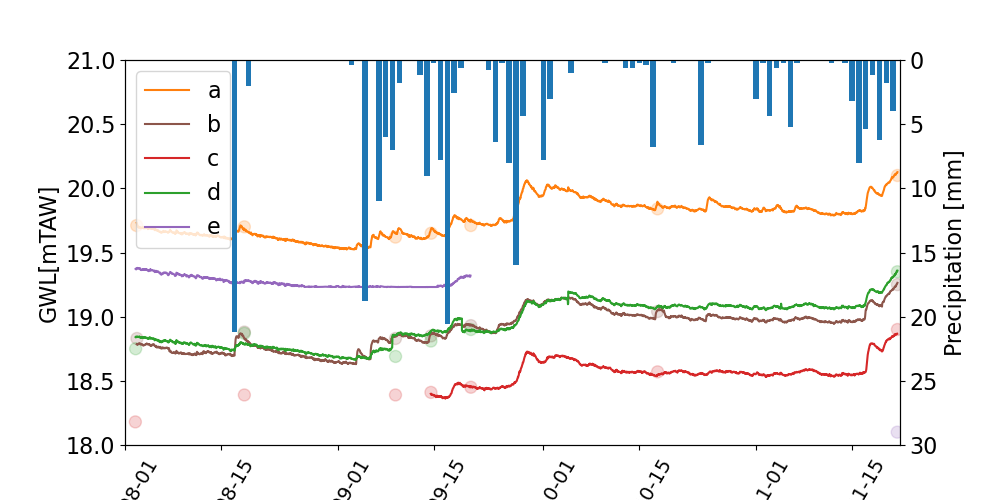

In [7]:
wellinfo = { 'SerialNumber' : ['AG083','AP707','CA186','AZ649','CA969'], 
            'WellName' : {'a','b','c','d','e'},
            'lgnds' : ['a','b','c','d','e'],
            'soil_mTAW' : [21.30,20.5,19.7,20.9,22.3],
            'well_height' : [0.56,0.43,0.63,0.68,0.70],
            'top_well_cm' :[2186,2093,2033,2158,2300],
            'RL' : [350,332,341,370,377],
            'L1':[294,289,278,302,307],
            'initials' : [158,165,147,225,0],
            'measure_time':['2022-08-02 17:30:00','2022-08-02 17:00:00',
                        '2022-08-02 15:00:00','2022-08-02 11:00:00',
                        '2021-08-02 13:00:00'],
           'long':[108855,108899,108929,108884,108814],
           'lat':[185311,185293,185281,185274,185203]}
alldata={}
dov={}
date1=datetime.date(2022,8,1)
date2=datetime.date(2022,11,22)
ftsz=16

fig, ax= plt.subplots(figsize=(10,5))
axb=ax.twinx()



for f,i in enumerate(wellinfo['SerialNumber']):
    ddd=GWdata.loc[GWdata["SerialNumber"]==i].reset_index()
    dataall=baro_data.merge(ddd[['TimeStamp','Pressure']], on='TimeStamp')
    dataall.SerialNumber=i
    dataall[dataall['Pressure_y'].notna()]
    dataall = dataall[dataall['Pressure_x']<dataall['Pressure_y']]
    dataall["WL"]=(dataall['Pressure_y']-dataall['Pressure_x'])
    dataall=dataall.reset_index()
    if wellinfo['SerialNumber'][f]=='AZ649':
        dataall.to_excel('saved_file.xlsx')
        # calculate GWL manually in Excel
        dataall["GWL"]=PiezoD["GWL"]
    else:
        dataall["GWL"]=-wellinfo['RL'][f]+wellinfo['top_well_cm'][f]+dataall["WL"]
    if wellinfo['SerialNumber'][f]=='AG083':
        dataA = dataall
        dataall.to_excel('saved_file_headA.xlsx')
    if wellinfo['SerialNumber'][f]=='AP707':
        dataB = dataall
        dataall.to_excel('saved_file_headB.xlsx')
    if wellinfo['SerialNumber'][f]=='CA186':
        dataC = dataall
        dataall.to_excel('saved_file_headC.xlsx')
    if wellinfo['SerialNumber'][f]=='AZ649':
        dataD = dataall
        dataall.to_excel('saved_file_headD.xlsx')
    if wellinfo['SerialNumber'][f]=='CA969':
        dataE = dataall
        dataall.to_excel('saved_file_headE.xlsx')
    if wellinfo['SerialNumber'][f]=='CA186':
        ax.plot(dataall.TimeStamp[840:],(dataall["GWL"][840:]/100),colors[i])
    else:
        ax.plot(dataall.TimeStamp,(dataall["GWL"]/100),colors[i])
    ax.set_ylim([18,21])
    alldata[i]=dataall


ax.scatter(df_info2.Time, df_info2.iloc[:,5], 75,c=df_info2['SerialNumber'].map(colors),alpha=.2, marker='o')
ax.legend(wellinfo['lgnds'],loc='upper left', fontsize=ftsz)
ax.set_ylabel('GWL[mTAW]', fontsize= ftsz)
ax.tick_params(axis='x', which='both', labelsize=ftsz-2,rotation=60)
ax.tick_params(axis='y', which='both', labelsize=ftsz)
#ax.hlines(y=21.3, xmin = date1, xmax = date2, color='#ff7f0e', linestyle = '--')
#ax.hlines(y=20.5, xmin = date1, xmax = date2,color='#8c564b', linestyle = '--')
#ax.hlines(y=19.7, xmin = date1, xmax = date2,color='#d62728', linestyle = '--')
#ax.hlines(y=20.9, xmin = date1, xmax = date2,color='#2ca02c', linestyle = '--')
#ax.hlines(y=22.3, xmin = date1, xmax = date2,color='#9467bd', linestyle = '--')


axb.bar(climday['date'],climday.precipitation_sum)
axb.set_ylim([0, 30])
axb.invert_yaxis()
axb.set_ylabel('Precipitation [mm]', fontsize= ftsz)
axb.tick_params(axis='x', which='both', labelsize=ftsz)
axb.tick_params(axis='y', which='both', labelsize=ftsz)

axb.set_xlim([date1,date2])

print(dataall)

In [8]:
## Below surface depth

      index MonitoringPoint SerialNumber           TimeStamp  Pressure_x  \
0         0            ILVO        CA969 2022-08-02 13:00:00    1037.700   
1         1            ILVO        CA969 2022-08-02 13:00:00    1037.700   
2         2            ILVO        CA969 2022-08-02 14:00:00    1037.650   
3         3            ILVO        CA969 2022-08-02 14:00:00    1037.650   
4         4            ILVO        CA969 2022-08-02 15:00:00    1036.825   
...     ...             ...          ...                 ...         ...   
1641   2078            ILVO        CA969 2022-09-20 05:00:00    1044.025   
1642   2079            ILVO        CA969 2022-09-20 06:00:00    1043.900   
1643   2080            ILVO        CA969 2022-09-20 07:00:00    1044.275   
1644   2081            ILVO        CA969 2022-09-20 08:00:00    1045.050   
1645   2082            ILVO        CA969 2022-09-20 09:00:00    1044.675   

      Temperature  Conductivity  WaterLevel  WaterLevelReference  \
0       31.850000  

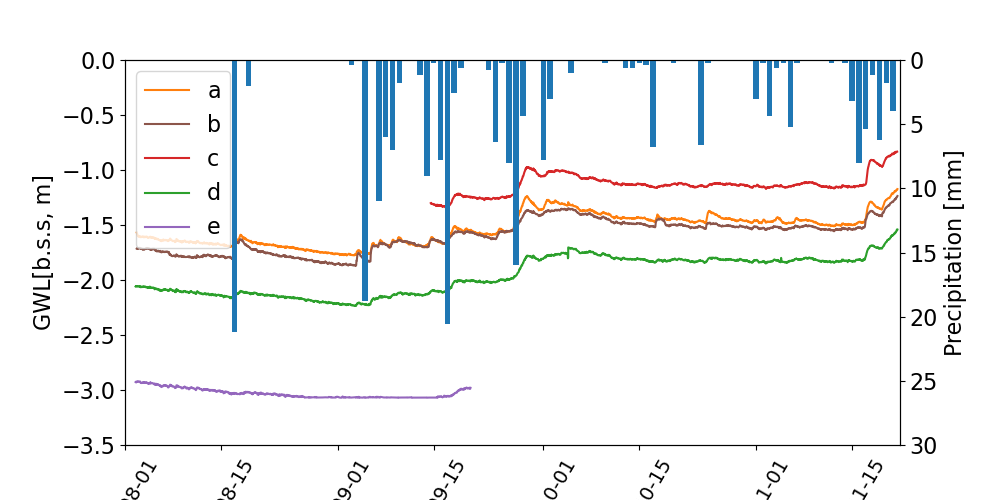

In [8]:
wellinfo = { 'SerialNumber' : ['AG083','AP707','CA186','AZ649','CA969'], 
            'WellName' : {'a','b','c','d','e'},
            'lgnds' : ['a','b','c','d','e'],
            'soil_mTAW' : [21.30,20.5,19.7,20.9,22.3],
            'well_height_m' : [56,43,63,68,70],
            'RL' : [350,332,341,370,377],
            'L1':[294,289,278,302,307],
            'initials' : [158,165,147,225,0],
            'measure_time':['2022-08-02 17:30:00','2022-08-02 17:00:00',
                        '2022-08-02 15:00:00','2022-08-02 11:00:00',
                        '2021-08-02 13:00:00'],
           'long':[108855,108899,108929,108884,108814],
           'lat':[185311,185293,185281,185274,185203]}
alldata1={}
date1=datetime.date(2022,8,1)
date2=datetime.date(2022,11,22)
ftsz=16

fig, ax= plt.subplots(figsize=(10,5))
axb=ax.twinx()

for f,i in enumerate(wellinfo['SerialNumber']):
    ddd1=GWdata.loc[GWdata["SerialNumber"]==i].reset_index()
    dataall1=baro_data.merge(ddd1[['TimeStamp','Pressure']], on='TimeStamp')
    dataall1.SerialNumber=i
    dataall1[dataall1['Pressure_y'].notna()]
    dataall1 = dataall1[dataall1['Pressure_x']<dataall1['Pressure_y']]
    dataall1["WL"]=(dataall1['Pressure_y']-dataall1['Pressure_x'])
    dataall1=dataall1.reset_index()
    if wellinfo['SerialNumber'][f]=='AZ649':
        dataall1["GWL"]=PiezoD["BSS"]
    else:
        dataall1["GWL"]=wellinfo['RL'][f]-wellinfo['well_height_m'][f]-dataall1["WL"]
    if wellinfo['SerialNumber'][f]=='CA186':
        ax.plot(dataall1.TimeStamp[840:],-( dataall1["GWL"][840:]/100),colors[i])
    else:
        ax.plot(dataall1.TimeStamp,-( dataall1["GWL"]/100),colors[i])
    ax.set_ylim([-3.5,0])
    alldata1[i]=dataall1
    

#ax.scatter(df_info2.Time, df_info2.iloc[:,4]/100, 75,c=df_info2['SerialNumber'].map(colors),alpha=.2, marker='o')
ax.legend(wellinfo['lgnds'],loc='upper left', fontsize=ftsz)
ax.set_ylabel('GWL[b.s.s, m]', fontsize= ftsz)
ax.tick_params(axis='x', which='both', labelsize=ftsz-2,rotation=60)
ax.tick_params(axis='y', which='both', labelsize=ftsz)



axb.bar(climday['date'],climday.precipitation_sum)
axb.set_ylim([0, 30])
axb.invert_yaxis()
axb.set_ylabel('Precipitation [mm]', fontsize= ftsz)
axb.tick_params(axis='x', which='both', labelsize=ftsz)
axb.tick_params(axis='y', which='both', labelsize=ftsz)

axb.set_xlim([date1,date2])

print(dataall1)

# calculate Gradients [H2-H1/(Distance)], 
# H mtaw between each pair of piezometer like (a,b), (b,c), (c,d),(b,d),(a,d)
| distance matrix | a | b | c | d | e |
|:-----------:|:-----------:|:--------------------:|:--------------------------------:|:---------------:|:------------|
|  a  |   -  |         47,621        |                 79,562                |      46,382      |  115,062  |
|   b   |   47,621   |         -       |              32,528               |      24,529      |  123,775    |
|   c  |   79,562   |       32,528         |            -                  |        45,460    |     138,869   |
|   d   |   46,382   |         24,529        |              45,460                |      -      |   99,504   |
|   e  |  115,062  |         123,775        |                138,869               |      99,504     |   -    |

In [26]:
### (a,b) ###
dataA1 = dataA.drop_duplicates(subset=['Date'])
dataB1 = dataB.drop_duplicates(subset=['Date'])
dataA1 = dataA1[['Date','GWL']]
dataB1 = dataB1[["Date", 'GWL']]
#dataB2 = dataB1.drop(dataB1.loc[dataB1['Date'] == '2022-11-04 11:00:00'].index)
dataA1 = dataA1.set_index('Date')
dataB1 = dataB1.set_index('Date')

In [27]:
diffAB = (dataA1['GWL'] - dataB2['GWL'])
hydgraAB = diffAB/4762.1 
hydgraAB = hydgraAB.reset_index()

In [28]:
plt.figure(figsize=(10,5))
plt.plot(hydgraAB['Date'], hydgraAB['GWL'])
plt.title('Hydraulic gradient (a,b)', fontsize = 25)
plt.ylabel('Hydraulic gradient', fontsize = 20)
plt.xlabel('Time', fontsize = 20)
plt.xticks(rotation = 45) 
plt.show

FigureCanvasNbAgg()

<function matplotlib.pyplot.show(*args, **kw)>

In [30]:
### (a,c) ###
dataC1 = dataC.drop_duplicates(subset=['Date'])
dataC2 = dataC1[['Date','GWL']]
#dataC2 = dataC2.drop(dataC2.loc[dataC['Date'] == '2022-08-02 15:00:00'].index)
#dataC2 = dataC2.drop(dataC2.loc[dataC['Date'] == '2022-08-02 16:00:00'].index)
#dataA1 = dataA1.reset_index()
#dataA2 = dataA1[(dataA1.Date < '2022-09-06 14:00:00') | (dataA1.Date > '2022-09-14 13:00:00')]
#dataA2 = dataA1.set_index('Date')
dataC2 = dataC2.set_index('Date')

In [31]:
diffAC = (dataA1['GWL'] - dataC2['GWL'])
hydgraAC = diffAC/7956.2 
hydgraAC = hydgraAC.reset_index()

In [32]:
plt.figure(figsize=(10,5))
plt.plot(hydgraAC.Date[840:], hydgraAC.GWL[840:])
plt.title('Hydraulic gradient (a,c)', fontsize = 25)
plt.ylabel('Hydraulic gradient', fontsize = 20)
plt.xlabel('Time', fontsize = 20)
plt.xticks(rotation = 45) 
plt.show

FigureCanvasNbAgg()

<function matplotlib.pyplot.show(*args, **kw)>

In [24]:
### (a,d) ###
dataD1 = dataD.drop_duplicates(subset=['Date'])
dataD2 = dataD1[['Date','GWL']]
dataD2 = dataD2.set_index('Date')
dataA2 = dataA1.set_index('Date')

In [25]:
diffAD = (dataA2['GWL'] - dataD2['GWL'])
hydgraAD = diffAD/4638.2 
hydgraAD = hydgraAD.reset_index()

In [33]:
plt.figure(figsize=(10,5))
plt.plot(hydgraAD.Date, hydgraAD.GWL)
plt.title('Hydraulic gradient (a,d)', fontsize = 25)
plt.ylabel('Hydraulic gradient', fontsize = 20)
plt.xlabel('Time', fontsize = 20)
plt.xticks(rotation = 45) 
plt.show

FigureCanvasNbAgg()

<function matplotlib.pyplot.show(*args, **kw)>

In [34]:
### (b,c) ###
diffBC = (dataB1['GWL'] - dataC2['GWL'])
hydgraBC = diffBC/3252.8
hydgraBC = hydgraBC.reset_index()

In [35]:
plt.figure(figsize=(10,5))
plt.plot(hydgraBC.Date[840:], hydgraBC.GWL[840:])
plt.title('Hydraulic gradient (b,c)', fontsize = 25)
plt.ylabel('Hydraulic gradient', fontsize = 20)
plt.xlabel('Time', fontsize = 20)
plt.xticks(rotation = 45) 
plt.show

FigureCanvasNbAgg()

<function matplotlib.pyplot.show(*args, **kw)>

In [41]:
### (b,d) ###
diffBD = (dataB1['GWL'] - dataD2['GWL'])
hydgraBD = diffBD/3252.8
hydgraBD = hydgraBD.reset_index()

In [42]:
plt.figure(figsize=(10,5))
plt.plot(hydgraBD.Date, hydgraBD.GWL)
plt.title('Hydraulic gradient (b,d)', fontsize = 25)
plt.ylabel('Hydraulic gradient', fontsize = 20)
plt.xlabel('Time', fontsize = 20)
plt.xticks(rotation = 45) 
plt.show

FigureCanvasNbAgg()

<function matplotlib.pyplot.show(*args, **kw)>

In [43]:
### (c,d) ###
diffCD = (dataC2['GWL'] - dataD2['GWL'])
hydgraCD = diffCD/3252.8
hydgraCD = hydgraCD.reset_index()

In [46]:
plt.figure(figsize=(10,5))
plt.plot(hydgraCD.Date[840:], hydgraCD.GWL[840:])
plt.title('Hydraulic gradient (c,d)', fontsize = 25)
plt.ylabel('Hydraulic gradient', fontsize = 20)
plt.ylim([-0.010,-0.020])
plt.xlabel('Time', fontsize = 20)
plt.xticks(rotation = 45) 
plt.show

FigureCanvasNbAgg()

<function matplotlib.pyplot.show(*args, **kw)>